In [1]:
import os
print(os.getcwd())


C:\Users\mahmoody\Desktop\gait_project\notebooks


synthetic signals for right and left foot motion

In [4]:
import numpy as np
import pandas as pd
fs = 100
time = np.arange(0 , 10 , 1/fs)

right_z = 0.02 * np.sin(2 * np.pi * time * 1.2) + 0.01
left_z = 0.02 * np.sin(2 * np.pi * time * 1.2 + np.pi) + 0.01

right_z += np.random.normal(0 , 0.002 , len(time))
left_z += np.random.normal(0 , 0.002 , len(time))

df = pd.DataFrame({
    "time" : time,
    "foot_right_z_m" : right_z,
    "foot_left_z_m" : left_z
})

df.to_csv("../data/synthetic_gait.csv", index = False)
print("done")
df.head()

done


,time,foot_right_z_m,foot_left_z_m
0,0.00,0.010125,0.008536
1,0.01,0.012016,0.010143
2,0.02,0.014852,0.006619
3,0.03,0.012512,0.004977
4,0.04,0.015505,0.003548


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("../data/synthetic_gait.csv")
df.head()

,time,foot_right_z_m,foot_left_z_m
0,0.00,0.010125,0.008536
1,0.01,0.012016,0.010143
2,0.02,0.014852,0.006619
3,0.03,0.012512,0.004977
4,0.04,0.015505,0.003548


height trajectories for both feet

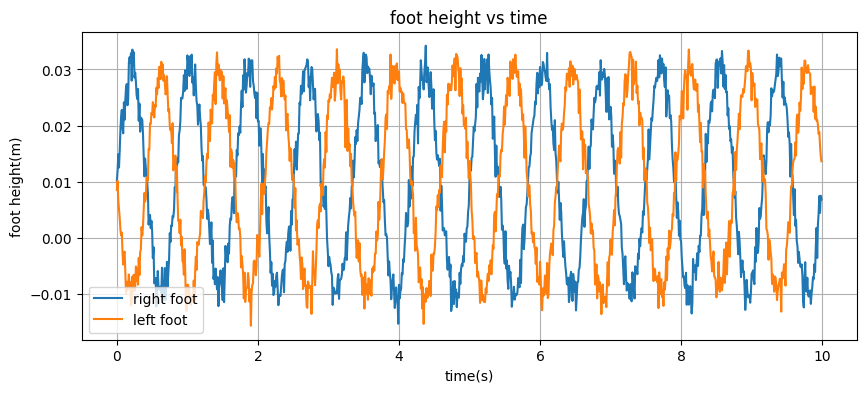

In [8]:
time = df["time"].values
right_z = df["foot_right_z_m"].values
left_z = df["foot_left_z_m"].values

plt.figure(figsize = (10,4))
plt.plot(time ,right_z ,label = "right foot")
plt.plot(time ,left_z , label = "left foot")

plt.xlabel("time(s)")
plt.ylabel("foot height(m)")
plt.title("foot height vs time")
plt.legend()
plt.grid(True)

heel strike points for Right foot

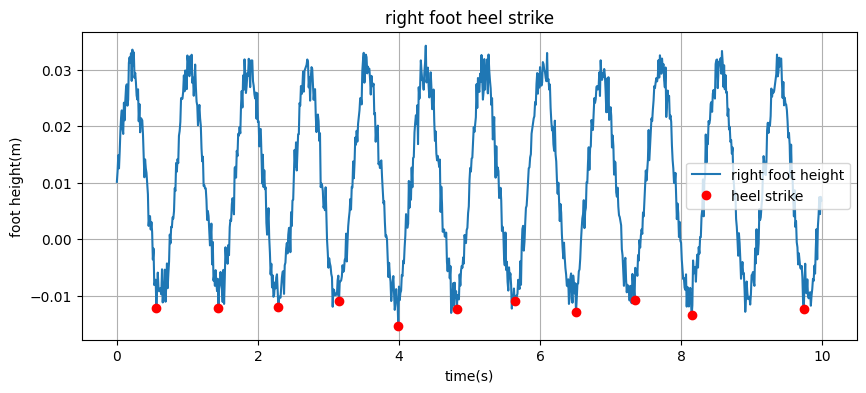

In [10]:
from scipy.signal import find_peaks

inverted_right = -right_z

peaks, _ = find_peaks(inverted_right , distance = 80)
plt.figure(figsize = (10,4))
plt.plot(time ,right_z ,label = "right foot height")
plt.plot(time[peaks] ,right_z[peaks] ,"ro" ,label = "heel strike")
plt.xlabel("time(s)")
plt.ylabel("foot height(m)")
plt.title("right foot heel strike")
plt.legend()
plt.grid(True)
plt.show()

heel strike points for both feet

right hs times: [0.56 1.44 2.29 3.15 3.99 4.82 5.64 6.51 7.34 8.15 9.74]
left hs times: [0.13 0.99 1.9  2.76 4.35 5.15 6.03 6.87 7.68 8.5  9.42]


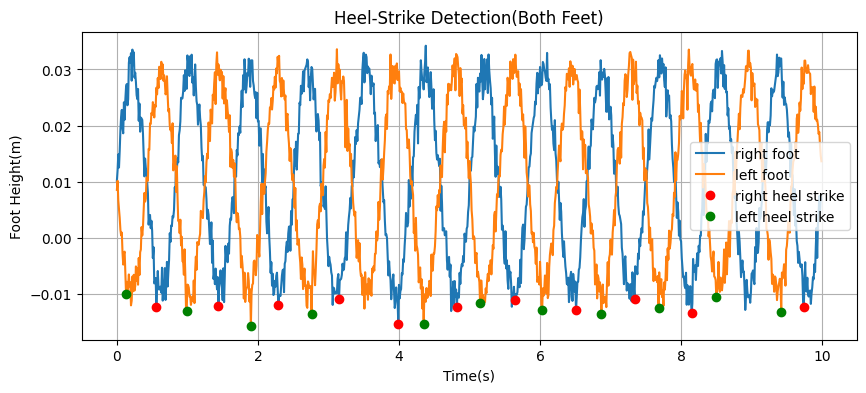

In [12]:
peaks_r, _ = find_peaks(-right_z , distance = 80)
hs_t_r = time[peaks_r]

peaks_l, _ = find_peaks(-left_z , distance = 80)
hs_t_l = time[peaks_l] 

print("right hs times:" , np.round(hs_t_r,3))
print("left hs times:" , np.round(hs_t_l,3))

plt.figure(figsize = (10,4))
plt.plot(time, right_z, label = "right foot")
plt.plot(time, left_z, label = "left foot")
plt.plot(hs_t_r ,right_z[peaks_r], "ro" , label = "right heel strike")
plt.plot(hs_t_l, left_z[peaks_l] , "go" , label = "left heel strike")
plt.xlabel("Time(s)")
plt.ylabel("Foot Height(m)")
plt.title("Heel-Strike Detection(Both Feet)")
plt.legend()
plt.grid(True)
plt.show()

metrics (stride time and cadence)

In [14]:
# Calculating the mean and standard deviation

def mean_and_std (x):
    return np.nanmean(x) , np.nanstd(x)

# Calculating the stride time

stride_r = np.diff(hs_t_r)
stride_l = np.diff(hs_t_l)
m_stride_r , s_stride_r = mean_and_std(stride_r)
m_stride_l , s_stride_l = mean_and_std(stride_l)

# calculating cadence

cadence_r = 120 / m_stride_r
cadence_l = 120 / m_stride_l
cadence_mean = np.nanmean([cadence_r, cadence_l])

# Normal or Irregular Walking Pattern

std_threshold = 0.05
status_r = "normal" if s_stride_r < std_threshold else "irregular"
status_l = "normal" if s_stride_l < std_threshold else "irregular"

print("Gait Summary Report:")
print(f"Right Stride Time : {m_stride_r:.3f} ± {s_stride_r:.3f} sec   →  {status_r}")
print(f"Left  Stride Time : {m_stride_l:.3f} ± {s_stride_l:.3f} sec   →  {status_l}")
print(f"Cadence (average) : {cadence_mean:.1f} steps/min")
if 70 < cadence_mean < 90 :
        print("slow walking")
elif 90 < cadence_mean < 120 :
        print("normal walking")
elif 120 < cadence_mean < 150 :
        print("fast walking")

Gait Summary Report:
Right Stride Time : 0.918 ± 0.225 sec   →  irregular
Left  Stride Time : 0.929 ± 0.224 sec   →  irregular
Cadence (average) : 129.9 steps/min
fast walking


Detecting Heel-Strike and Toe-Off Events and Calculating Stance Phase Percentage

In [16]:
thresh = 0.01 #meter
# z > thresh   swing phase
# z < thresh   stance phase
stance_mask_r = right_z <= thresh
stance_mask_l = left_z <= thresh

stance_percent_r = 100 * stance_mask_r.mean()
stance_percent_l = 100 * stance_mask_l.mean()

def detect_hs_to(stance_mask , time):
    transition = np.diff(stance_mask.astype(int))
    #transition = +1  heel strike
    # transition = -1  toe off
    hs_idx = np.where(transition == 1)[0] +1
    to_idx = np.where(transition == -1)[0] + 1
    return time[hs_idx] , time[to_idx]

hs_r , to_r = detect_hs_to(stance_mask_r , time)
hs_l , to_l = detect_hs_to(stance_mask_l , time)

print(f"stance right : {stance_percent_r:.1f}%\n")
print(f"stance left : {stance_percent_l:.1f}%\n")
print(f"right heel strike : {np.round(hs_r,3)}\n")
print(f"right toe off : {np.round(to_r,3)}\n")
print(f"left heel strike : {np.round(hs_l,3)}\n")
print(f"left toe off : {np.round(to_l,3)}\n")

stance right : 50.3%

stance left : 48.9%

right heel strike : [0.43 1.23 2.06 2.08 2.1  2.89 3.77 4.15 4.17 4.19 4.59 5.42 6.25 6.67
 7.08 7.9  7.93 8.32 8.75 9.59]

right toe off : [0.84 1.67 2.07 2.09 2.51 3.35 4.14 4.16 4.18 4.2  5.   5.83 6.66 6.68
 7.5  7.92 8.31 8.33 9.16]

left heel strike : [0.02 0.84 0.86 1.26 1.69 2.51 3.33 4.17 4.19 5.02 5.83 6.69 7.52 8.31
 8.35 8.76 9.2 ]

left toe off : [0.01 0.42 0.85 1.25 1.27 2.1  2.93 3.75 4.18 4.59 5.41 6.25 7.09 7.92
 8.32 8.75 8.77 9.58]



symmetry analysis between right and left foot :

symmetry index(stance phase) : 2.82%



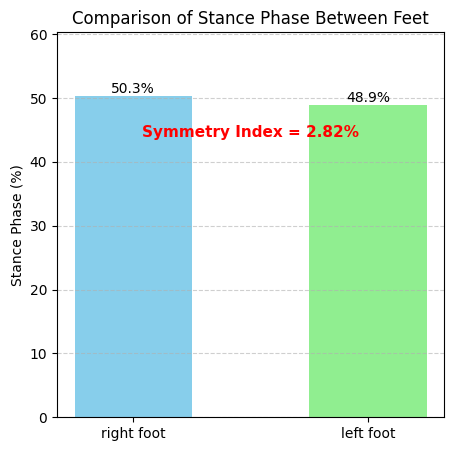

In [19]:
symmetry_stance = 100 * abs(stance_percent_r - stance_percent_l) / ((stance_percent_r + stance_percent_l)/2)
print(f"symmetry index(stance phase) : {symmetry_stance:.2f}%\n")

# bar chart:
labels = ['right foot' , 'left foot']
stance_values = [stance_percent_r , stance_percent_l ]

plt.figure(figsize = (5,5))
bars = plt.bar(labels , stance_values , color = ['skyblue' , 'lightgreen'] , width = 0.5)
plt.ylabel('Stance Phase (%)')
plt.title('Comparison of Stance Phase Between Feet')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 , yval + 0.5 , f'{yval:.1f}%' , ha = 'center' , fontsize = 10)

plt.text(0.5, min(stance_values) - 5, f'Symmetry Index = {symmetry_stance:.2f}%', 
         ha='center', fontsize=11, color='red', weight='bold')

plt.ylim(0, max(stance_values) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

joint kinematics

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# gait cycle (0 - 100 %)
gait_cycle = np.linspace(0, 100, 200)

# synthetic data
hip_angle   = 20 * np.sin(2 * np.pi * gait_cycle / 100)  # Hip: ±20°
knee_angle  = 60 - 30 * np.cos(2 * np.pi * gait_cycle / 100)  # Knee: 30–90°
ankle_angle = 10 * np.sin(4 * np.pi * gait_cycle / 100)  # Ankle: ±10°


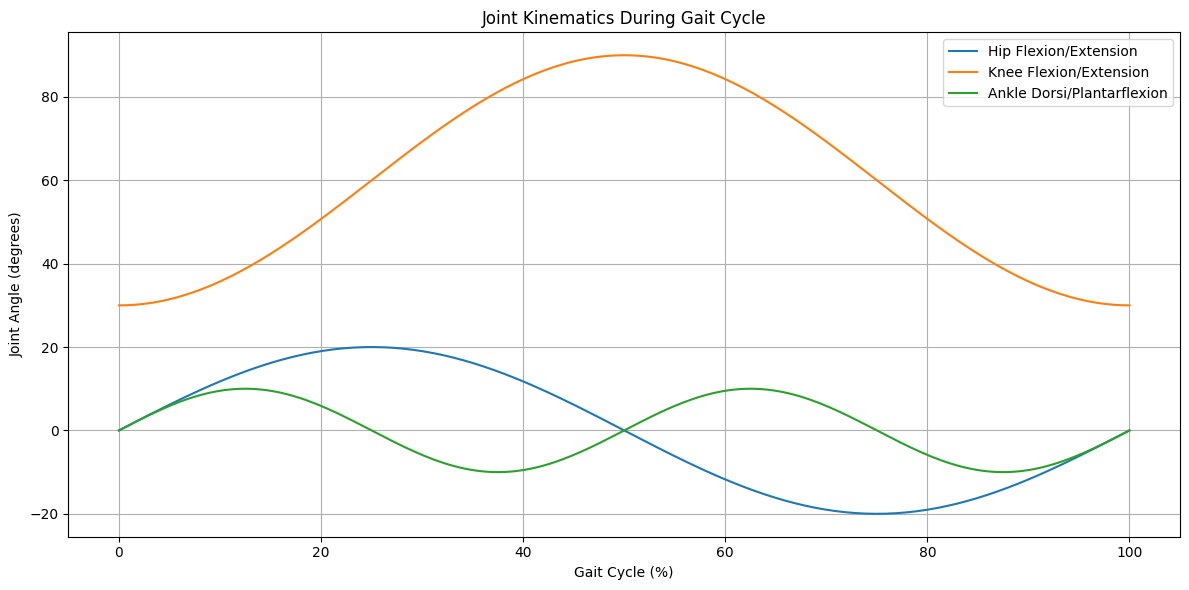

In [32]:
plt.figure(figsize=(12, 6))

plt.plot(gait_cycle, hip_angle, label="Hip Flexion/Extension")
plt.plot(gait_cycle, knee_angle, label="Knee Flexion/Extension")
plt.plot(gait_cycle, ankle_angle, label="Ankle Dorsi/Plantarflexion")

plt.title("Joint Kinematics During Gait Cycle")
plt.xlabel("Gait Cycle (%)")
plt.ylabel("Joint Angle (degrees)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
